In [1]:
%config Completer.use_jedi = False

# Importing packages

In [2]:
import nltk
from nltk.corpus import stopwords
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=16,progress_bar=True)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [74]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import SnowballStemmer
from nltk import WordNetLemmatizer, pos_tag, word_tokenize
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

# Intialiazing Stemmer and Lemmmatizer Object

In [75]:
stemmer = SnowballStemmer("english")
lemma = WordNetLemmatizer()
stop_words = set(gensim.parsing.preprocessing.STOPWORDS)
stop_words.update(['game', 'play', 'good', 'fun', 'like', 'time', 'great', 'buy', 'player', 'get', 'friend', 'people', 'server', 'best', 'hour', 'bad', 'love', 'online', 'money', 'want'])

# Loading Data

In [5]:
df = pd.read_csv("file:///home/vegito/Machine_learning/DATASET/steam_reviews.csv")
df.columns

Index(['date_posted', 'funny', 'helpful', 'hour_played',
       'is_early_access_review', 'recommendation', 'review', 'title'],
      dtype='object')

In [6]:
df.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


#  Checking null Data

In [7]:
df.isna().sum()

date_posted                  0
funny                        0
helpful                      0
hour_played                  0
is_early_access_review       0
recommendation               0
review                    1516
title                        0
dtype: int64

In [8]:
df['title'].value_counts()

PLAYERUNKNOWN'S BATTLEGROUNDS                    145685
Grand Theft Auto V                                99956
Rust                                              71088
Rocket League®                                    67907
Dead by Daylight                                  22221
MONSTER HUNTER: WORLD                             18412
ASTRONEER                                          2661
The Elder Scrolls V: Skyrim Special Edition        1473
RESIDENT EVIL 2 / BIOHAZARD RE:2                   1385
Sid Meier’s Civilization® VI                        522
Euro Truck Simulator 2                              501
Slay the Spire                                      260
Terraria                                            260
Subnautica                                          247
Left 4 Dead 2                                       221
Insurgency: Sandstorm                               220
RimWorld                                            204
Stardew Valley                                  

In [9]:
df.dropna(inplace=True)

In [10]:
df.isna().sum()

date_posted               0
funny                     0
helpful                   0
hour_played               0
is_early_access_review    0
recommendation            0
review                    0
title                     0
dtype: int64

# Sampling Data

In [11]:
df = df.sample((df.shape[0]//2)//2)


In [12]:
df.shape

(108343, 8)

In [13]:

df = df[["review","title"]]
df.head()

,review,title
0,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,Disclaimer I survivor main. I play games for f...,Dead by Daylight


# Lemmantization and Stemming

In [14]:
def lemantize_stemming(word, pos_tag):
    """
    {
    'n': ['NN', 'NNS', 'NNP', 'NNPS'],
    'v': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
    'r': ['RB', 'RBR', 'RBS'],
    'a': ['JJ', 'JJR', 'JJS']
    }
    
    """
    try:
        # checking tag us adverb or adjective or not
        pos_label = "a" if pos_tag[0].lower() == "j" else pos_tag[0].lower()
        new_word = ""
        if pos_label in ('r'):  # For adverbs it's a bit different
            new_word =  wordnet.synset(word+'.r.1').lemmas()[0].pertainyms()[0].name()
        elif pos_label in ('a', 's', 'v'): # For adjectives and verbs
            new_word =  lemma.lemmatize(word, pos=pos_label)
        else:   # For nouns and everything else as it is the default kwarg
            new_word =  lemma.lemmatize(word)
    except Exception:
        new_word = word
#     stemmed_word = stemmer.stem(word) 

    return new_word

def preprocess_text(text,common_words=[]):
    # preprocessing like removing empty string and lowering text
    text = " ".join([token for token in gensim.utils.simple_preprocess(text,min_len=1,max_len=40)])
    # words with tags
    pos_label = pos_tag(word_tokenize(text))
    # lemmatizing and stemming words by pos
    result = [lemantize_stemming(word, pos) for word,pos in pos_label if word not in stop_words and len(word) > 2]
    if common_words:
        result = [word for word in result if word not in common_words]
    return result

In [131]:
# Applying Cleaning Text

In [15]:
df["process_text"] = df["review"].parallel_apply(preprocess_text)

In [16]:
df.head()

,review,title,process_text
0,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,"[play, german, reich, declare, war, belgium, b..."
1,yes.,Expansion - Hearts of Iron IV: Man the Guns,[yes]
2,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns,"[bit, overprice, opinion, prefer, play, mod, h..."
3,Out of all the reviews I wrote This one is pro...,Dead by Daylight,"[review, write, probably, write, starter, comm..."
4,Disclaimer I survivor main. I play games for f...,Dead by Daylight,"[disclaimer, survivor, main, game, competition..."


In [17]:
long_string = ""
for tokens in df['process_text'].to_list():
    for tok in tokens:
        long_string += "," + tok


# WordCloud

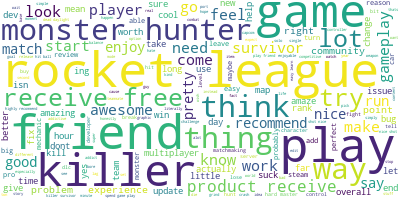

In [18]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

In [19]:
# from collections import Counter
# all_words = Counter(long_string.split(","))
# del long_string
# del wordcloud


In [132]:
# common_words = [word for word, _ in all_words.most_common(20)]
# print(common_words)

# Creating Document Term matrix and Bag of Words

In [20]:
data_words = [i for i in df['process_text'].to_list() if len(i) > 2]
id2word = gensim.corpora.Dictionary(data_words)

In [21]:
corpus = [id2word.doc2bow(text) for text in data_words]

In [26]:
from pprint import pprint

In [24]:
def build_lda_model(corpus,id2word,num_topics = 2,passes=1,decay=0.5,iterations=50,print=True):
    lda_model = gensim.models.LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        passes=passes,
        decay=decay,
        iterations=iterations,
        chunksize = 10000,
        eval_every = None
        )# Print the Keyword in the 10 topics
    if print:
        pprint(lda_model.print_topics(num_topics=num_topics, num_words=20))
    return lda_model

# Checking Number of topics with Coherence of model

In [29]:
coherence = []
for k in range(5,25):
    print('Round: '+str(k))

    ldamodel = build_lda_model(
        corpus,
        id2word,
        num_topics=k,
        decay=0.5,
        iterations=10,
        passes=10
    )
    print("="*50)
    cm = gensim.models.coherencemodel.CoherenceModel(
         model=ldamodel, texts=data_words,
         dictionary=id2word, coherence='c_v'
        )                                     
    coherence.append((k,cm.get_coherence()))

Round: 5
[(0,
  '0.026*"free" + 0.020*"product" + 0.019*"receive" + 0.013*"fix" + '
  '0.011*"dont" + 0.011*"ban" + 0.011*"cheater" + 0.010*"yes" + 0.009*"update" '
  '+ 0.009*"lot" + 0.008*"problem" + 0.008*"day" + 0.007*"regionlockchina" + '
  '0.007*"know" + 0.006*"thing" + 0.006*"go" + 0.006*"league" + 0.005*"rocket" '
  '+ 0.005*"die" + 0.005*"start"'),
 (1,
  '0.012*"hacker" + 0.010*"lag" + 0.009*"recommend" + 0.009*"bug" + '
  '0.007*"fix" + 0.007*"lot" + 0.007*"new" + 0.007*"better" + 0.007*"monster" '
  '+ 0.006*"way" + 0.006*"issue" + 0.006*"thing" + 0.006*"work" + '
  '0.005*"update" + 0.005*"worth" + 0.005*"story" + 0.005*"pubg" + 0.005*"gta" '
  '+ 0.005*"look" + 0.004*"feel"'),
 (2,
  '0.011*"kill" + 0.011*"car" + 0.008*"rust" + 0.007*"killer" + 0.007*"need" + '
  '0.006*"base" + 0.006*"new" + 0.005*"let" + 0.005*"build" + 0.005*"run" + '
  '0.005*"start" + 0.005*"make" + 0.005*"way" + 0.005*"think" + '
  '0.004*"survival" + 0.004*"go" + 0.004*"rock" + 0.004*"survivor" + 

Round: 9
[(0,
  '0.056*"free" + 0.044*"product" + 0.042*"receive" + 0.017*"nice" + '
  '0.017*"pubg" + 0.016*"regionlockchina" + 0.012*"bug" + 0.012*"fortnite" + '
  '0.010*"update" + 0.008*"optimize" + 0.007*"new" + 0.007*"better" + '
  '0.006*"optimization" + 0.005*"try" + 0.005*"map" + 0.005*"fix" + '
  '0.005*"gud" + 0.005*"run" + 0.005*"dinner" + 0.005*"chicken"'),
 (1,
  '0.018*"kappa" + 0.014*"killer" + 0.012*"monster" + 0.011*"recommend" + '
  '0.010*"lag" + 0.009*"survivor" + 0.007*"awesome" + 0.007*"new" + '
  '0.006*"hunter" + 0.006*"rank" + 0.005*"worth" + 0.005*"learn" + '
  '0.005*"gameplay" + 0.005*"enjoy" + 0.005*"easy" + 0.004*"hard" + '
  '0.004*"experience" + 0.004*"skill" + 0.004*"team" + 0.004*"win"'),
 (2,
  '0.019*"gta" + 0.017*"story" + 0.013*"yes" + 0.012*"graphic" + '
  '0.011*"community" + 0.010*"multiplayer" + 0.009*"mission" + 0.009*"world" + '
  '0.007*"worth" + 0.007*"character" + 0.007*"gameplay" + 0.005*"experience" + '
  '0.005*"mode" + 0.005*"lot" + 0

Round: 12
[(0,
  '0.021*"lag" + 0.021*"issue" + 0.017*"fix" + 0.014*"run" + 0.014*"fps" + '
  '0.012*"problem" + 0.009*"recommend" + 0.008*"work" + 0.007*"low" + '
  '0.007*"update" + 0.007*"bug" + 0.007*"setting" + 0.007*"need" + '
  '0.006*"crash" + 0.006*"look" + 0.006*"lot" + 0.006*"optimize" + '
  '0.006*"load" + 0.005*"new" + 0.005*"high"'),
 (1,
  '0.031*"community" + 0.014*"modding" + 0.014*"way" + 0.011*"experience" + '
  '0.008*"toxic" + 0.007*"mod" + 0.007*"year" + 0.006*"team" + 0.006*"group" + '
  '0.006*"review" + 0.006*"better" + 0.005*"know" + 0.005*"think" + '
  '0.005*"base" + 0.005*"thing" + 0.005*"new" + 0.005*"support" + 0.004*"look" '
  '+ 0.004*"amp" + 0.004*"content"'),
 (2,
  '0.037*"hacker" + 0.017*"ing" + 0.017*"dont" + 0.013*"let" + 0.013*"pubg" + '
  '0.013*"fix" + 0.011*"cheat" + 0.010*"ban" + 0.010*"hack" + 0.010*"cheater" '
  '+ 0.010*"chinese" + 0.010*"bug" + 0.009*"battle" + 0.009*"kill" + '
  '0.009*"crash" + 0.007*"royale" + 0.006*"update" + 0.006*"b

Round: 14
[(0,
  '0.025*"fix" + 0.019*"issue" + 0.019*"bug" + 0.018*"run" + 0.013*"crash" + '
  '0.012*"yes" + 0.010*"problem" + 0.008*"battle" + 0.008*"fps" + 0.007*"work" '
  '+ 0.007*"machine" + 0.007*"need" + 0.007*"look" + 0.007*"release" + '
  '0.006*"recommend" + 0.006*"lot" + 0.006*"greene" + 0.006*"brendan" + '
  '0.006*"optimization" + 0.006*"high"'),
 (1,
  '0.036*"mod" + 0.020*"single" + 0.020*"gta" + 0.013*"story" + '
  '0.009*"multiplayer" + 0.009*"mode" + 0.008*"mission" + 0.007*"content" + '
  '0.006*"rockstar" + 0.006*"go" + 0.006*"heist" + 0.006*"new" + 0.006*"make" '
  '+ 0.006*"modding" + 0.005*"recommend" + 0.005*"singleplayer" + 0.005*"way" '
  '+ 0.005*"experience" + 0.005*"support" + 0.005*"need"'),
 (2,
  '0.057*"hacker" + 0.014*"hack" + 0.013*"cheater" + 0.012*"chinese" + '
  '0.011*"cheat" + 0.010*"kill" + 0.010*"fix" + 0.007*"problem" + 0.006*"dont" '
  '+ 0.005*"anti" + 0.005*"say" + 0.005*"way" + 0.005*"try" + 0.004*"china" + '
  '0.004*"bug" + 0.004*"wow"

Round: 16
[(0,
  '0.021*"monster" + 0.010*"hunter" + 0.009*"weapon" + 0.007*"world" + '
  '0.007*"feel" + 0.006*"new" + 0.006*"series" + 0.006*"look" + 0.006*"long" + '
  '0.005*"auto" + 0.005*"far" + 0.005*"grand" + 0.005*"hunt" + 0.005*"go" + '
  '0.005*"character" + 0.005*"thing" + 0.005*"theft" + 0.005*"way" + '
  '0.004*"come" + 0.004*"fight"'),
 (1,
  '0.056*"lag" + 0.022*"regionlockchina" + 0.021*"fix" + 0.020*"review" + '
  '0.016*"better" + 0.013*"bug" + 0.013*"problem" + 0.012*"issue" + '
  '0.008*"amazing" + 0.008*"update" + 0.007*"lot" + 0.007*"nice" + '
  '0.006*"patch" + 0.006*"know" + 0.006*"recommend" + 0.006*"graphic" + '
  '0.006*"change" + 0.005*"network" + 0.005*"performance" + 0.005*"release"'),
 (2,
  '0.011*"map" + 0.009*"match" + 0.008*"run" + 0.006*"bug" + 0.006*"loot" + '
  '0.006*"die" + 0.006*"gun" + 0.006*"right" + 0.006*"shoot" + 0.005*"pretty" '
  '+ 0.005*"feel" + 0.005*"bit" + 0.005*"terrible" + 0.005*"issue" + '
  '0.005*"fix" + 0.005*"go" + 0.005*"hit

Round: 18
[(0,
  '0.035*"killer" + 0.020*"survivor" + 0.007*"match" + 0.007*"lot" + '
  '0.007*"need" + 0.006*"chicken" + 0.006*"perk" + 0.005*"dinner" + '
  '0.005*"way" + 0.005*"rank" + 0.005*"hook" + 0.005*"balance" + 0.004*"feel" '
  '+ 0.004*"horror" + 0.004*"level" + 0.004*"try" + 0.004*"dead" + '
  '0.004*"camp" + 0.004*"enjoy" + 0.004*"think"'),
 (1,
  '0.048*"ing" + 0.022*"chinese" + 0.015*"match" + 0.010*"damn" + 0.009*"fix" '
  '+ 0.008*"god" + 0.008*"make" + 0.006*"cheat" + 0.006*"need" + 0.006*"work" '
  '+ 0.006*"official" + 0.006*"trash" + 0.005*"try" + 0.005*"hacker" + '
  '0.005*"cheating" + 0.005*"win" + 0.004*"bluehole" + 0.004*"pubg" + '
  '0.004*"rank" + 0.004*"dont"'),
 (2,
  '0.031*"let" + 0.024*"battle" + 0.022*"lot" + 0.020*"royale" + 0.015*"far" + '
  '0.015*"bowl" + 0.015*"nico" + 0.012*"busyservers" + 0.011*"optimization" + '
  '0.010*"need" + 0.008*"rekt" + 0.008*"fix" + 0.008*"update" + '
  '0.007*"especially" + 0.006*"problem" + 0.006*"fps" + 0.006*"prett

Round: 20
[(0,
  '0.032*"rock" + 0.025*"naked" + 0.013*"man" + 0.010*"guy" + 0.010*"wow" + '
  '0.009*"life" + 0.008*"toxic" + 0.007*"men" + 0.006*"kill" + 0.006*"beat" + '
  '0.005*"dude" + 0.005*"head" + 0.005*"cup" + 0.005*"salt" + 0.004*"wadu" + '
  '0.004*"community" + 0.004*"minute" + 0.004*"black" + 0.004*"run" + '
  '0.004*"hek"'),
 (1,
  '0.032*"worth" + 0.026*"crash" + 0.019*"regionlockchina" + 0.012*"new" + '
  '0.010*"release" + 0.009*"update" + 0.008*"recommend" + 0.008*"price" + '
  '0.008*"steam" + 0.006*"dollar" + 0.006*"experience" + 0.006*"little" + '
  '0.006*"content" + 0.006*"review" + 0.005*"spend" + 0.005*"issue" + '
  '0.005*"look" + 0.005*"start" + 0.005*"year" + 0.005*"definitely"'),
 (2,
  '0.036*"killer" + 0.026*"cheater" + 0.022*"survivor" + 0.017*"lock" + '
  '0.014*"region" + 0.012*"china" + 0.007*"need" + 0.006*"chinese" + '
  '0.006*"team" + 0.006*"bug" + 0.006*"perk" + 0.006*"kill" + 0.006*"devs" + '
  '0.005*"match" + 0.005*"hook" + 0.005*"rank" + 0.0

Round: 22
[(0,
  '0.047*"run" + 0.020*"fps" + 0.019*"die" + 0.014*"high" + 0.013*"setting" + '
  '0.011*"low" + 0.011*"graphic" + 0.010*"bug" + 0.009*"weapon" + 0.009*"gtx" '
  '+ 0.008*"gun" + 0.008*"spawn" + 0.008*"ram" + 0.007*"end" + 0.007*"drop" + '
  '0.006*"kill" + 0.006*"hard" + 0.006*"loot" + 0.006*"average" + '
  '0.005*"land"'),
 (1,
  '0.041*"ing" + 0.017*"cheater" + 0.016*"cheat" + 0.016*"ban" + 0.015*"dont" '
  '+ 0.015*"waste" + 0.013*"fix" + 0.012*"worth" + 0.008*"year" + 0.008*"need" '
  '+ 0.008*"problem" + 0.007*"hacker" + 0.007*"anti" + 0.007*"stupid" + '
  '0.007*"bluehole" + 0.006*"care" + 0.006*"update" + 0.006*"work" + '
  '0.006*"trash" + 0.006*"terrible"'),
 (2,
  '0.070*"lag" + 0.031*"community" + 0.025*"gta" + 0.015*"busyservers" + '
  '0.009*"step" + 0.008*"toxic" + 0.007*"make" + 0.007*"cancer" + '
  '0.006*"modding" + 0.006*"year" + 0.006*"mod" + 0.006*"gaming" + '
  '0.006*"guess" + 0.005*"say" + 0.005*"old" + 0.005*"skyrim" + 0.005*"wait" + '
  '0.005*"

Round: 24
[(0,
  '0.040*"better" + 0.012*"rip" + 0.011*"openiv" + 0.010*"come" + 0.009*"pubg" '
  '+ 0.008*"make" + 0.008*"new" + 0.008*"change" + 0.008*"improve" + '
  '0.006*"way" + 0.006*"issue" + 0.006*"graphic" + 0.006*"old" + 0.006*"run" + '
  '0.005*"go" + 0.005*"thing" + 0.005*"wait" + 0.005*"release" + 0.005*"year" '
  '+ 0.004*"lot"'),
 (1,
  '0.136*"free" + 0.110*"product" + 0.105*"receive" + 0.030*"machine" + '
  '0.027*"greene" + 0.027*"brendan" + 0.017*"need" + 0.009*"nice" + '
  '0.005*"fix" + 0.005*"alwayschicken" + 0.004*"recommend" + 0.004*"alpha" + '
  '0.004*"realy" + 0.003*"run" + 0.003*"try" + 0.003*"work" + 0.003*"thing" + '
  '0.002*"pretty" + 0.002*"awesome" + 0.002*"cool"'),
 (2,
  '0.047*"update" + 0.031*"new" + 0.021*"map" + 0.017*"fix" + 0.014*"cool" + '
  '0.013*"pay" + 0.012*"dont" + 0.012*"add" + 0.009*"need" + 0.008*"rekt" + '
  '0.007*"come" + 0.006*"day" + 0.006*"go" + 0.006*"car" + 0.006*"look" + '
  '0.006*"thing" + 0.006*"event" + 0.006*"stuff" + 0

In [30]:
x = []
y = []
for i,j in coherence:
    x.append(i)
    y.append(j)

#  Plotting Coherence according to Topic Number

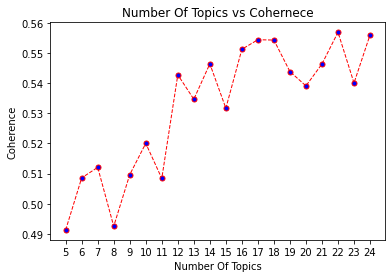

In [33]:
plt.title("Number Of Topics vs Cohernece")
plt.xlabel("Number Of Topics")
plt.ylabel("Coherence")
plt.plot(x,y,
         color='red',
         linestyle='dashed', 
         linewidth = 1, 
         marker='o', 
         markerfacecolor='blue', 
         markersize=5
        )
plt.rcParams["figure.figsize"]=(10,6)
plt.xticks(x)
plt.show()

In [133]:
# Reference

In [ ]:
#https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
#https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2
#https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# Evaluating with PylDAvis

In [22]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
pyLDAvis.enable_notebook()
num_topics = 12

In [27]:
lda_model = build_lda_model(corpus,
        id2word,
        num_topics=num_topics,
        decay=0.0,
        iterations=250,
        passes=50
)



[(0,
  '0.048*"win" + 0.041*"pretty" + 0.040*"hard" + 0.030*"rank" + 0.029*"pay" + '
  '0.022*"bug" + 0.021*"job" + 0.020*"wait" + 0.017*"far" + 0.016*"hour" + '
  '0.010*"player" + 0.008*"think" + 0.008*"nice" + 0.007*"need" + '
  '0.007*"price" + 0.007*"average" + 0.007*"short" + 0.006*"lose" + '
  '0.006*"kid" + 0.006*"long"'),
 (1,
  '0.043*"save" + 0.042*"wow" + 0.019*"com" + 0.016*"disable" + 0.015*"chat" + '
  '0.015*"iti" + 0.013*"second" + 0.011*"http" + 0.010*"que" + '
  '0.009*"lagggslaggg" + 0.008*"www" + 0.008*"youtube" + 0.007*"watch" + '
  '0.006*"jogo" + 0.004*"mom" + 0.004*"son" + 0.004*"para" + 0.004*"https" + '
  '0.004*"baby" + 0.004*"juego"'),
 (2,
  '0.028*"ing" + 0.018*"fix" + 0.018*"ban" + 0.017*"dont" + 0.015*"community" '
  '+ 0.013*"bad" + 0.011*"toxic" + 0.010*"lose" + 0.010*"trash" + 0.009*"get" '
  '+ 0.009*"bug" + 0.009*"crash" + 0.008*"civ" + 0.008*"devs" + 0.008*"say" + '
  '0.007*"know" + 0.007*"suck" + 0.006*"report" + 0.006*"player" + '
  '0.006*"err

In [134]:
# Saving Model

In [28]:
lda_model.save('model/lda.model')

In [29]:

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


/home/vegito/anaconda3/envs/pynlp/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/vegito/anaconda3/envs/pynlp/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [30]:
pyLDAvis.save_html(LDAvis_prepared, "topics_"+str(num_topics) +'.html')

## TFIDF Approach

In [31]:
bow_100 = corpus[100]

In [32]:
for i in range(len(bow_100)):
    print("Word {} (\"{}\") appears {} time.".format(bow_100[i][0], 
                                                     id2word[bow_100[i][0]], 
                                                     bow_100[i][1]))


Word 44 ("hear") appears 1 time.
Word 241 ("friend") appears 1 time.
Word 447 ("scary") appears 1 time.
Word 659 ("pretty") appears 1 time.
Word 814 ("receive") appears 1 time.
Word 1083 ("free") appears 1 time.
Word 1087 ("product") appears 1 time.
Word 1591 ("faint") appears 1 time.
Word 1592 ("freinds") appears 1 time.
Word 1593 ("loud") appears 1 time.


In [33]:
from gensim import corpora, models

tfidf = models.TfidfModel(corpus)

In [34]:
corpus_tfidf = tfidf[corpus]

In [35]:

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.24472416653415677),
 (1, 0.6886140049479224),
 (2, 0.2295380016493075),
 (3, 0.08513602232358775),
 (4, 0.24472416653415677),
 (5, 0.15293300080856606),
 (6, 0.1702073168773296),
 (7, 0.410936999554106),
 (8, 0.18539348176217887),
 (9, 0.10983088457328763),
 (10, 0.03473081883158907),
 (11, 0.22065466466190228),
 (12, 0.11025267523232823),
 (13, 0.12799570214087164)]


In [36]:
# lda_model2 = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=id2word, workers=4,passes=50,iterations=200)

In [37]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.048*"win" + 0.041*"pretty" + 0.040*"hard" + 0.030*"rank" + 0.029*"pay" + 0.022*"bug" + 0.021*"job" + 0.020*"wait" + 0.017*"far" + 0.016*"hour"
Topic: 1 
Words: 0.043*"save" + 0.042*"wow" + 0.019*"com" + 0.016*"disable" + 0.015*"chat" + 0.015*"iti" + 0.013*"second" + 0.011*"http" + 0.010*"que" + 0.009*"lagggslaggg"
Topic: 2 
Words: 0.028*"ing" + 0.018*"fix" + 0.018*"ban" + 0.017*"dont" + 0.015*"community" + 0.013*"bad" + 0.011*"toxic" + 0.010*"lose" + 0.010*"trash" + 0.009*"get"
Topic: 3 
Words: 0.042*"monster" + 0.019*"hunter" + 0.014*"weapon" + 0.009*"world" + 0.008*"feel" + 0.008*"fight" + 0.008*"hunt" + 0.008*"new" + 0.007*"story" + 0.006*"series"
Topic: 4 
Words: 0.041*"new" + 0.034*"dlc" + 0.026*"update" + 0.023*"add" + 0.019*"content" + 0.017*"item" + 0.015*"map" + 0.015*"crate" + 0.014*"pay" + 0.014*"join"
Topic: 5 
Words: 0.187*"free" + 0.139*"product" + 0.139*"receive" + 0.016*"weekend" + 0.013*"nice" + 0.012*"gud" + 0.007*"funny" + 0.006*"cool" + 0.005*"git

In [38]:
### Tfidf lda model
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=id2word, passes=50, workers=4,iterations=200)

In [39]:
lda_model_tfidf.save("model/lda_model_tfidf.model")

In [40]:


for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))



Topic: 0 Word: 0.013*"wheel" + 0.010*"mac" + 0.008*"hot" + 0.007*"playstation" + 0.007*"mario" + 0.006*"nuff" + 0.005*"kart" + 0.003*"verry" + 0.003*"material" + 0.003*"nintendo"
Topic: 1 Word: 0.008*"training" + 0.008*"cutscenes" + 0.006*"dis" + 0.005*"calculate" + 0.005*"tbh" + 0.004*"asia" + 0.003*"thx" + 0.003*"gamble" + 0.003*"worst" + 0.003*"jet"
Topic: 2 Word: 0.022*"port" + 0.009*"mission" + 0.007*"bos" + 0.005*"denuvo" + 0.005*"craft" + 0.004*"pickup" + 0.004*"plz" + 0.004*"grand" + 0.003*"ultrawide" + 0.003*"peasant"
Topic: 3 Word: 0.017*"car" + 0.016*"rocket" + 0.013*"play" + 0.012*"league" + 0.011*"friend" + 0.010*"game" + 0.010*"football" + 0.009*"hour" + 0.008*"easy" + 0.008*"ball"
Topic: 4 Word: 0.013*"basketball" + 0.012*"paced" + 0.010*"badge" + 0.010*"ign" + 0.005*"lit" + 0.005*"linux" + 0.005*"funnest" + 0.004*"rpg" + 0.004*"dude" + 0.003*"gam"
Topic: 5 Word: 0.017*"gud" + 0.014*"trading" + 0.008*"penny" + 0.008*"supersonic" + 0.006*"gaem" + 0.005*"award" + 0.005*"gi

In [41]:
data_words[100]

['product',
 'receive',
 'free',
 'friend',
 'freinds',
 'faint',
 'hear',
 'pretty',
 'loud',
 'scary']

In [42]:
for index, score in sorted(lda_model[corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 16)))


Score: 0.39261406660079956	 
Topic: 0.052*"killer" + 0.033*"survivor" + 0.009*"perk" + 0.007*"play" + 0.007*"hook" + 0.007*"get" + 0.006*"bug" + 0.006*"friend" + 0.006*"dead" + 0.006*"rank" + 0.006*"kill" + 0.006*"way" + 0.006*"horror" + 0.006*"try" + 0.006*"need" + 0.005*"balance"

Score: 0.30821481347084045	 
Topic: 0.187*"free" + 0.139*"product" + 0.139*"receive" + 0.016*"weekend" + 0.013*"nice" + 0.012*"gud" + 0.007*"funny" + 0.006*"cool" + 0.005*"git" + 0.005*"awsome" + 0.005*"salt" + 0.004*"cup" + 0.003*"dis" + 0.003*"gift" + 0.003*"egg" + 0.003*"awesome"

Score: 0.23088933527469635	 
Topic: 0.062*"play" + 0.039*"friend" + 0.032*"hour" + 0.027*"game" + 0.025*"get" + 0.018*"recommend" + 0.017*"worth" + 0.013*"think" + 0.013*"buy" + 0.011*"awesome" + 0.010*"enjoy" + 0.009*"dont" + 0.009*"day" + 0.009*"year" + 0.009*"lot" + 0.009*"amazing"


In [43]:
for index, score in sorted(lda_model_tfidf[corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 16)))


Score: 0.45574629306793213	 
Topic: 0.019*"game" + 0.015*"play" + 0.014*"easy" + 0.012*"skill" + 0.012*"friend" + 0.012*"learn" + 0.011*"player" + 0.011*"competitive" + 0.010*"gameplay" + 0.010*"master" + 0.010*"match" + 0.010*"league" + 0.010*"rocket" + 0.009*"hard" + 0.009*"simple" + 0.008*"lot"

Score: 0.396138995885849	 
Topic: 0.044*"match" + 0.031*"server" + 0.024*"lag" + 0.023*"lobby" + 0.022*"join" + 0.020*"minute" + 0.016*"ping" + 0.014*"fix" + 0.013*"leave" + 0.011*"matchmaking" + 0.011*"wait" + 0.010*"screen" + 0.009*"time" + 0.008*"ready" + 0.008*"quit" + 0.008*"start"

Score: 0.07988689094781876	 
Topic: 0.031*"issue" + 0.019*"fix" + 0.013*"run" + 0.013*"review" + 0.012*"problem" + 0.011*"work" + 0.010*"controller" + 0.010*"connection" + 0.010*"multiplayer" + 0.009*"fps" + 0.009*"mouse" + 0.009*"play" + 0.009*"port" + 0.008*"console" + 0.007*"release" + 0.007*"recommend"


In [46]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, id2word)
pyLDAvis.save_html(LDAvis_prepared, "topics_"+str(num_topics) +'tfidf.html')

/home/vegito/anaconda3/envs/pynlp/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/vegito/anaconda3/envs/pynlp/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


# Testing model on unseen document¶


In [45]:
unseen_document = """
Don't listen to people who claim it's the game only for Adeptus Mechanicus lore fans I had zero knowledge about AdMech (coming from that minority who prefers Warhammer Fantasy Battles to 40k) and I'm really enjoying it. It's fun has soul and spirit is not overcomplicated or frustrating.+ Great atmosphere (especially banter and disputes between characters who give missions and track the progress of your squad during missions)+ Solid tactical game with some good ideas+ Good customization options for your TechPriests+ The story is interesting enough the dialogues are fun+ Nice OST really helps to immerse Only one enemy faction (Necrons). But it's the matter of Games Workshop licence and not really developer's fault. Besides Necrons are the most fitting xenos enemy for AdMech lorewise. Once you level up and customize your TechPriests well enough the game becomes much easier. It's still fun for me but might not please those who want more challenge. Level mission maps seem to be scripted and static not randomly created (I might be wrong though),"Warhammer 40,000: Mechanicus
"""
bow_vector = id2word.doc2bow(preprocess_text(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\n Topic: {}".format(score, lda_model.print_topic(index, 20)))



Score: 0.4683294892311096
 Topic: 0.042*"monster" + 0.019*"hunter" + 0.014*"weapon" + 0.009*"world" + 0.008*"feel" + 0.008*"fight" + 0.008*"hunt" + 0.008*"new" + 0.007*"story" + 0.006*"series" + 0.006*"thing" + 0.006*"game" + 0.006*"quest" + 0.006*"look" + 0.005*"combat" + 0.005*"lot" + 0.005*"grind" + 0.004*"kill" + 0.004*"big" + 0.004*"way"

Score: 0.27834054827690125
 Topic: 0.019*"game" + 0.015*"play" + 0.014*"easy" + 0.012*"skill" + 0.012*"friend" + 0.012*"learn" + 0.011*"player" + 0.011*"competitive" + 0.010*"gameplay" + 0.010*"master" + 0.010*"match" + 0.010*"league" + 0.010*"rocket" + 0.009*"hard" + 0.009*"simple" + 0.008*"lot" + 0.008*"mode" + 0.008*"sport" + 0.008*"recommend" + 0.007*"team"

Score: 0.07417421787977219
 Topic: 0.041*"new" + 0.034*"dlc" + 0.026*"update" + 0.023*"add" + 0.019*"content" + 0.017*"item" + 0.015*"map" + 0.015*"crate" + 0.014*"pay" + 0.014*"join" + 0.012*"free" + 0.011*"key" + 0.009*"gamefailed" + 0.008*"get" + 0.007*"cosmetic" + 0.007*"developer" +

# Filtering Text with only noun words

In [78]:
def preprocess_text_pos_tag(text,common_words=[],lemantize_tag = []):
    # preprocessing like removing empty string and lowering text
    text = " ".join([token for token in gensim.utils.simple_preprocess(text,min_len=1,max_len=40)])
    # words with tags
    pos_label = pos_tag(word_tokenize(text))
    # lemmatizing and stemming words by pos
    if lemantize_tag:
        result = [stemmer.stem(word) for word,pos in pos_label if word not in stop_words and len(word) > 2 and pos in lemantize_tag]
    else:
        result = [lemantize_stemming(word, pos) for word,pos in pos_label if word not in stop_words and len(word) > 2]
    if common_words:
        result = [word for word in result if word not in common_words]
    return result

In [79]:
preprocess_text_pos_tag("Domini and Dominae I believe what we are deali..",lemantize_tag=['NN', 'NNS', 'NNP', 'NNPS'])

['domini', 'domina']

In [80]:
data_words_with_pos_tag = []
for i in df['review'].to_list():
    noun_text = preprocess_text_pos_tag(i,lemantize_tag=['NN', 'NNS', 'NNP', 'NNPS']) 
    if len(noun_text) > 1:
        data_words_with_pos_tag.append(noun_text)


In [82]:
id2word = gensim.corpora.Dictionary(data_words_with_pos_tag)
corpus = [id2word.doc2bow(text) for text in data_words]

In [83]:
ldamodel_pos_tag = build_lda_model(
        corpus,
        id2word,
        num_topics=12,
        decay=0.5,
        iterations=250,
        passes=60
    )

[(0,
  '0.059*"server" + 0.054*"fix" + 0.050*"ing" + 0.036*"lag" + 0.022*"ping" + '
  '0.018*"hate" + 0.016*"bad" + 0.014*"bug" + 0.014*"stop" + 0.014*"crash" + '
  '0.013*"trash" + 0.013*"dont" + 0.012*"problem" + 0.012*"need" + '
  '0.010*"suck" + 0.010*"psyonix" + 0.009*"internet" + 0.009*"say" + '
  '0.009*"pls" + 0.007*"que"'),
 (1,
  '0.072*"killer" + 0.046*"survivor" + 0.013*"perk" + 0.012*"play" + '
  '0.011*"rank" + 0.011*"get" + 0.010*"hook" + 0.010*"match" + 0.009*"dead" + '
  '0.009*"player" + 0.008*"bug" + 0.008*"kill" + 0.008*"way" + 0.008*"balance" '
  '+ 0.008*"need" + 0.007*"map" + 0.007*"point" + 0.007*"thing" + 0.007*"camp" '
  '+ 0.006*"escape"'),
 (2,
  '0.231*"friend" + 0.054*"recommend" + 0.051*"play" + 0.033*"save" + '
  '0.027*"lot" + 0.024*"solo" + 0.022*"wow" + 0.018*"better" + 0.017*"job" + '
  '0.016*"chat" + 0.015*"think" + 0.014*"group" + 0.013*"enjoy" + '
  '0.009*"second" + 0.008*"time" + 0.007*"blast" + 0.007*"queue" + '
  '0.007*"good" + 0.007*"amazin

In [85]:
LDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel_pos_tag, corpus, id2word)


/home/vegito/anaconda3/envs/pynlp/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/vegito/anaconda3/envs/pynlp/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [86]:
pyLDAvis.save_html(LDAvis_prepared, "topics_"+str(num_topics) +'pos.html')

In [87]:
ldamodel_pos_tag.save("model/pos_lda_model.model")

#### Pos Tag model Is gud For topic Model but can be imporve with other addjective and nount 

# Load Model

In [70]:

# lma_model = gensim.models.ldamodel.LdaModel.load("lda.model")

In [103]:

for i in df['review'].to_list()[:2]:
    bow = id2word.doc2bow(preprocess_text_pos_tag(i,lemantize_tag=['NN', 'NNS', 'NNP', 'NNPS']))
    top_topics = ldamodel_pos_tag.get_document_topics(bow, minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(num_topics)] # number_of_topics


[0.010566782, 0.01056696, 0.010566802, 0.010566782, 0.010566915, 0.34355742, 0.010566782, 0.010567062, 0.010566999, 0.010566877, 0.30755866, 0.25378194]
[0.04166768, 0.04166844, 0.04166773, 0.041668683, 0.041668788, 0.041668456, 0.04166798, 0.041668307, 0.04166842, 0.041668408, 0.041668136, 0.541649]


In [119]:
def predic_topic(text):
    bow = id2word.doc2bow(preprocess_text_pos_tag(text, lemantize_tag=['NN', 'NNS', 'NNP', 'NNPS']))
    return sorted(ldamodel_pos_tag[bow], key=lambda tup: -1*tup[1])[0]

In [120]:
a = "Don't listen to people who claim it's the game only for Adeptus Mechanicus lore fans I had zero knowledge about AdMech (coming from that minority who prefers Warhammer Fantasy Battles to 40k) and I'm really enjoying it. It's fun has soul and spirit is not overcomplicated or frustrating.+ Great atmosphere (especially banter and disputes between characters who give missions and track the progress of your squad during missions)+ Solid tactical game with some good ideas+ Good customization options for your TechPriests+ The story is interesting enough the dialogues are fun+ Nice OST really helps to immerse Only one enemy faction (Necrons). But it's the matter of Games Workshop licence and not really developer's fault. Besides Necrons are the most fitting xenos enemy for AdMech lorewise. Once you level up and customize your TechPriests well enough the game becomes much easier. It's still fun for me but might not please those who want more challenge. Level mission maps seem to be scripted and static not randomly created (I might be wrong though)"

In [121]:
predic_topic(a)

(8, 0.510087)

In [124]:
df['topic_target'] = df["review"].apply(lambda x: predic_topic(x)[0] )

In [127]:
df.to_csv("sample.csv",index=False)

# Saving Topic Keywords in Text File

In [129]:
ldamodel_pos_tag.print_topic(109, topn=20)

In [130]:
with open('model/topic_file', 'w') as topic_file:
    topics = ldamodel_pos_tag.top_topics(corpus)
    topic_file.write('\n'.join('%s %s' %topic for topic in topics))


#### model Saved in following Link
#### Link
# https://drive.google.com/drive/folders/1Zt2pbBkIEb-rwYqRAiWDc0ln1vHykhhb?usp=sharing